# Data Analysis for project Olist
GitHub location: https://github.com/LarsTinnefeld/Olist-order-profile-analysis

Structure of this notebook:

1) Data Import and Preparation

2) Exploratory Data Analysis
- Units per order
- Lines per order
- Units per order line
- Pareto curve units
- Pareto curve order lines
- XYZ profile

3) 



---
## Data Preparation
### Importing libraries

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

### Importing datasets
This dataset stems from the previous data analysis (olist_ecom_analysis)

In [21]:
df_orders_consolidated = pd.read_csv('df_orders_consolidated.csv')

In [22]:
df_orders_consolidated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102422 entries, 0 to 102421
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Unnamed: 0                     102422 non-null  int64  
 1   order_id                       102422 non-null  object 
 2   customer_id                    102422 non-null  object 
 3   order_status                   102422 non-null  object 
 4   order_purchase_timestamp       102422 non-null  object 
 5   order_approved_at              102408 non-null  object 
 6   order_delivered_carrier_date   101395 non-null  object 
 7   order_delivered_customer_date  102422 non-null  object 
 8   order_estimated_delivery_date  102422 non-null  object 
 9   date_ordinal                   102422 non-null  int64  
 10  shipping_time_delta            102422 non-null  int64  
 11  shipping_duration              102422 non-null  int64  
 12  estimated_duration            

---
# Exploratory data analysis

---
## Order composition

In [23]:
df_order_class_comp = df_orders_consolidated.groupby([
    'order_id',
    'product_category_name'
    ]).agg({
        'product_id': 'count',
        'qty': 'sum',
        'price': 'sum',
        'order_line_cube_in_ltr': 'sum',
        'product_weight_g': 'sum',
        'estimated_duration': 'first',
        'shipping_duration': 'first',
        'shipping_time_delta': 'first',
        'order_purchase_timestamp': 'first'
        }).reset_index()

In [24]:
df_order_class_comp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98017 entries, 0 to 98016
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   order_id                  98017 non-null  object 
 1   product_category_name     98017 non-null  object 
 2   product_id                98017 non-null  int64  
 3   qty                       98017 non-null  int64  
 4   price                     98017 non-null  float64
 5   order_line_cube_in_ltr    98017 non-null  float64
 6   product_weight_g          98017 non-null  float64
 7   estimated_duration        98017 non-null  int64  
 8   shipping_duration         98017 non-null  int64  
 9   shipping_time_delta       98017 non-null  int64  
 10  order_purchase_timestamp  98017 non-null  object 
dtypes: float64(3), int64(5), object(3)
memory usage: 8.2+ MB


---
## How many units are in an order? => Units per order

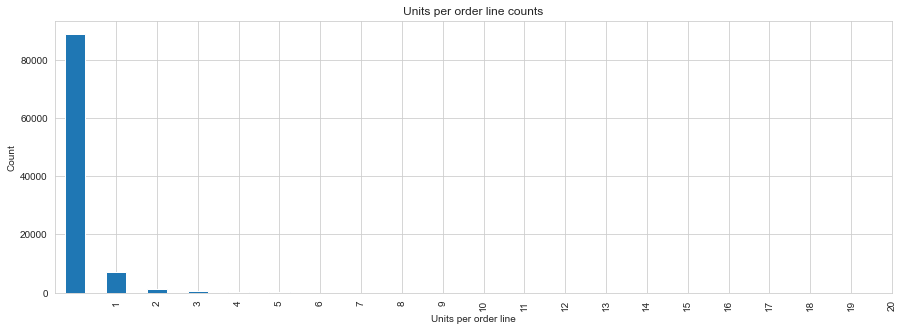

In [25]:
upl_range = np.arange(1, df_order_class_comp['qty'].max(), 1)
plt.xlabel('Units per order line')
plt.ylabel('Count')
(df_order_class_comp['qty'].value_counts()).plot(
                                            kind='bar',
                                            figsize = (15, 5),
                                            xticks = upl_range,
                                            title = 'Units per order line counts'
                                            );

In [26]:
df_upo_lpo = df_orders_consolidated.groupby('order_id').agg({'qty': 'sum', 'product_id': 'count'}).reset_index()
df_upo_lpo.rename(columns = {'qty': 'units', 'product_id': 'lines'}, inplace = True)

In [27]:
df_upo_lpo

,order_id,units,lines
0,00010242fe8c5a6d1ba2dd792cb16214,1,1
1,00018f77f2f0320c557190d7a144bdd3,1,1
2,000229ec398224ef6ca0657da4fc703e,1,1
3,00024acbcdf0a6daa1e931b038114c75,1,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,1
...,...,...,...
98659,fffc94f6ce00a00581880bf54a75a037,1,1
98660,fffcd46ef2263f404302a634eb57f7eb,1,1
98661,fffce4705a9662cd70adb13d4a31832d,1,1
98662,fffe18544ffabc95dfada21779c9644f,1,1


Plotting units/order and lines/order distribution

[Text(0.5, 1.0, 'Order lines per order profile'),
 Text(0.5, 0, 'order lines per order')]

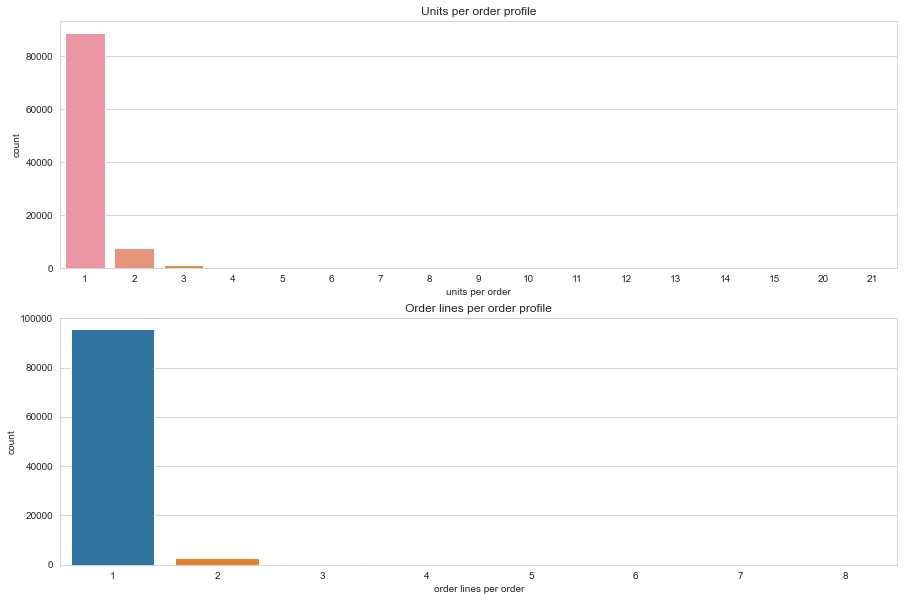

In [28]:
fig, ax = plt.subplots(2, 1, figsize = (15, 10))
sns.countplot(df_upo_lpo['units'], ax = ax[0])
sns.countplot(df_upo_lpo['lines'], ax = ax[1])
ax[0].set(title = 'Units per order profile', xlabel = 'units per order')
ax[1].set(title = 'Order lines per order profile', xlabel = 'order lines per order')

This looks typical e-commerce: mostly SIO (single item orders); two-step-order picking is an option to deal with this (batch pick, sort, pack)

### Generating pareto diagrams
We will base them on different metrics:
- units
- lines
- volume (cube)

Step 1: Creating a SKU list with aggregated values

In [29]:
df_orders_consolidated.columns

Index(['Unnamed: 0', 'order_id', 'customer_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'date_ordinal', 'shipping_time_delta',
       'shipping_duration', 'estimated_duration', 'product_id', 'qty',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'order_line_cube_in_ltr', 'price_round'],
      dtype='object')

In [30]:
df_SKUs = df_orders_consolidated\
    .groupby('product_id')\
    .agg({'qty': 'sum',
        'order_id': 'count',
        'order_line_cube_in_ltr': 'sum',
        'price': 'sum',
        'shipping_duration': 'mean'})

In [31]:
df_SKUs.rename(columns = {'qty': 'total_qty', 'order_id': 'total_lines', 'order_line_cube_in_ltr': 'total_cube', 'shipping_duration': 'avg_ship_duration'}, inplace = True)

In [32]:
df_SKUs

,total_qty,total_lines,total_cube,price,avg_ship_duration
product_id,,,,,
00066f42aeeb9f3007548bb9d3f33c38,1,1,5.120,101.65,17.0
00088930e925c41fd95ebfe695fd2655,1,1,14.300,129.90,11.0
0009406fd7479715e4bef61dd91f2462,1,1,23.625,229.00,16.0
000b8f95fcb9e0096488278317764d19,2,2,10.944,117.80,6.5
000d9be29b5207b54e86aa1b1ac54872,1,1,3.630,199.00,7.0
...,...,...,...,...,...
fff6177642830a9a94a0f2cba5e476d1,2,2,31.500,229.98,9.0
fff81cc3158d2725c0655ab9ba0f712c,1,1,2.816,90.00,2.0
fff9553ac224cec9d15d49f5a263411f,1,1,2.288,32.00,10.0


Need to sort by quantity, then add a cummulating percent counter for unit based pareto.

In [33]:
df_SKUs.sort_values(by='total_qty', ascending = False, inplace = True)

In [34]:
df_SKUs['cum_qty'] = df_SKUs['total_qty'].cumsum()/df_SKUs['total_qty'].sum()

Plotting unit-pareto

<AxesSubplot:xlabel='product_id'>

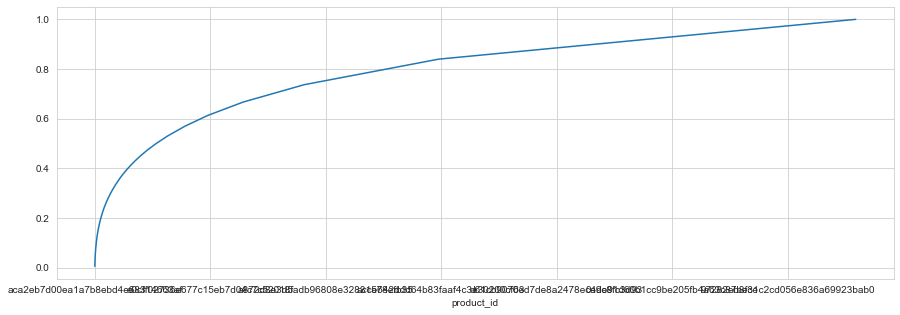

In [35]:
df_SKUs['cum_qty'].plot(figsize = (15, 5))